# CLEVR-MRT example dataset visualisation

In [1]:
import json
import torch
from skimage.io import imread
import numpy as np

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Extracting dataset

Because the dataset is quite massive, we will play around with a small sample of it here. Download `clevr-mrt-v2-sample.tar.gz` from and extract its contents. The 'v2' here refers to the version of the dataset described in Table X of the original paper.

In [10]:
%%bash 
cd data
tar -xvzf clevr-mrt-v2-sample.tar.gz >/dev/null 2>&1

In [12]:
%%bash
ls -lt data/clevr-mrt-v2-sample/

total 0
drwxr-xr-x  5 beckhamc  staff  160 25 Dec 13:48 metadata
drwxr-xr-x  4 beckhamc  staff  128 25 Dec 13:47 train-val


When we extract the folder, we will see three directories: `train-val` and `metadata` (for the full dataset, there will also be a held-out test set called `test`). The `train-val` directory consists of many subfolders that are identified by indices. These indices don't carry any meaning and are simply byproducts of generating the dataset in parallel when we did this internally. Essentially, each subfolder is a batch of scenes and questions, and all of the indices together comprise the entire dataset.

In [14]:
%%bash
ls -lt data/clevr-mrt-v2-sample/train-val

total 0
drwxr-xr-x  6 beckhamc  staff  192 25 Dec 13:47 217
drwxr-xr-x  6 beckhamc  staff  192 25 Dec 13:44 120


Examining one of these indices will look familiar if you've played with the original Clevr dataset:

In [15]:
%%bash
ls data/clevr-mrt-v2-sample/train-val/217

images
questions.json
scenes
scenes.json


In [36]:
DATADIR="data/clevr-mrt-v2-sample/train-val/"

-----

## Scenes

Let's read in the scenes.json of these indices.

In [18]:
scenes = json.loads(open("data/clevr-mrt-v2-sample/train-val/217/scenes.json").read())
#print(scenes.keys())
len(scenes['scenes']) # there are 100 scenes per index

100

In [19]:
scenes.keys()

dict_keys(['scenes', 'info'])

Each scene consists of 20 cameras, randomly sampled in a 360 degree arc. `cc` refers to the 'canonical camera', which is what the corresponding questions (in `questions.json`) are posed with respect to.

In [20]:
scenes['scenes'][0].keys()

dict_keys(['cam16', 'cam0', 'cam2', 'cam1', 'cam18', 'cam7', 'cam12', 'cam9', 'cam19', 'cam17', 'cc', 'cam15', 'cam4', 'cam10', 'cam13', 'cam3', 'cam5', 'cam6', 'cam11', 'cam8', 'cam14'])

Let us visualise a random subset (16) of these cameras.

In [27]:
cam_names = list(scenes['scenes'][0].keys())
np.random.shuffle(cam_names)

In [28]:
cam_names_subset = list(cam_names)[0:16]
cam_names_subset

['cc',
 'cam17',
 'cam18',
 'cam14',
 'cam15',
 'cam3',
 'cam7',
 'cam8',
 'cam1',
 'cam11',
 'cam19',
 'cam13',
 'cam5',
 'cam4',
 'cam2',
 'cam9']

In [29]:
scenes['scenes'][0][ cam_names_subset[0] ]['image_filename']

'CLEVR_train-clevr-kiwi-spatial_s021700_cc.png'

We can see that image filenames are of the form `CLEVR_train-clevr-kiwi-spatial_sX_Y.jpg`, where X is a unique scene identifier and Y denotes the camera number. If Y is `cc`, this means it is the canonical camera (the viewpoint which questions are posed with respect to).

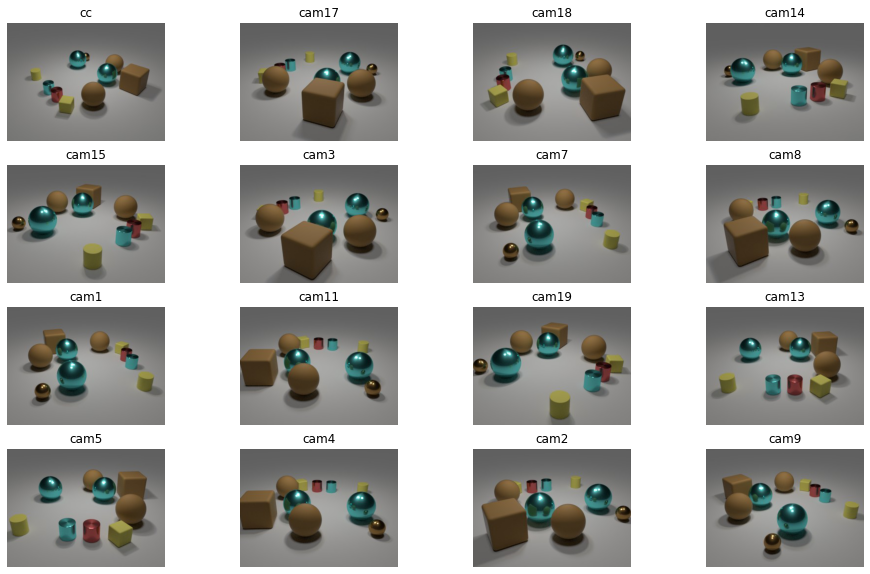

In [31]:
plt.figure(figsize=(16,10))
plt.tight_layout()
for j in range(16):
    plt.subplot(4,4,j+1)
    img = imread("data/clevr-mrt-v2-sample/train-val/217/images/%s" % \
                 scenes['scenes'][0][ cam_names_subset[j] ]['image_filename'].replace(".png",".jpg"))
    plt.imshow(img)
    plt.axis('off')
    plt.title(cam_names_subset[j])

Here is the canonical camera. While the canonical camera is fixed to the same position (i.e. same world 3d coordinates) for every scene in the dataset, in principle it should not be able to be easily determined by eyeballing the images, since we made an effort to ensure that there were no landmarks in the dataset (e.g. directional lighting) that could give hints as to what its position is. In other words, unless you have the 3d coordinates of the camera pertaining to the image, it should not be possible to determine the canonical camera's coordinates.

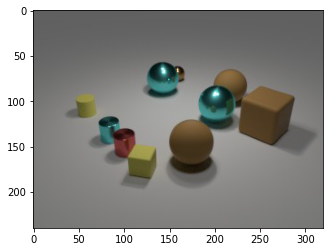

In [34]:
img_canonical = imread("data/clevr-mrt-v2-sample/train-val/217/images/%s" % \
                 scenes['scenes'][0]['cc']['image_filename'].replace(".png",".jpg"))
plt.imshow(img_canonical)

-----

## Questions

In [38]:
questions = json.loads(open("{}/217/questions.json".format(DATADIR)).read())
questions.keys()

dict_keys(['info', 'questions'])

In [39]:
q1 = questions['questions'][0]
q1['question']

'Are there the same number of large brown balls in front of the yellow rubber cylinder and small green rubber cubes?'

In [40]:
q1['answer']

False

In [41]:
q1['image_filename']

'CLEVR_train-clevr-kiwi-spatial_s021700_cc.png'

In [42]:
for question in questions['questions']:
    if "CLEVR_train-clevr-kiwi-spatial_s021700" in question['image_filename']:
        print("Q:", question['question'])
        print("  A:", question['answer'])

Q: Are there the same number of large brown balls in front of the yellow rubber cylinder and small green rubber cubes?
  A: False
Q: Is the number of big brown objects that are behind the tiny metal ball less than the number of small cubes?
  A: True
Q: Are there more large brown matte things that are in front of the tiny red metal cylinder than matte cubes?
  A: False
Q: Are there an equal number of tiny yellow things that are in front of the small cube and tiny cyan shiny things that are to the right of the small brown sphere?
  A: True
Q: Are there fewer small metal cylinders behind the small red object than brown cubes on the left side of the tiny metallic sphere?
  A: False
Q: Is the number of yellow matte cubes that are behind the small red cylinder greater than the number of yellow blocks that are in front of the large brown cube?
  A: False
Q: There is a brown ball that is in front of the yellow cylinder; is it the same size as the tiny yellow block?
  A: False
Q: There is a ye

-------

## PyTorch dataset

These json files are not used directly with the corresponding dataset class in PyTorch. The `metadata` folder contains preprocessed versions of these files in h5py format:

In [46]:
%%bash
ls data/clevr-mrt-v2-sample/metadata

train_questions.h5
valid_questions.h5
vocab.json


In [47]:
# Courtesy of: https://github.com/ethanjperez/film
def invert_dict(d):
    return {v: k for k, v in d.items()}

# Courtesy of: https://github.com/ethanjperez/film
def load_vocab(path):
    with open(path, 'r') as f:
        vocab = json.load(f)
        vocab['question_idx_to_token'] = invert_dict(vocab['question_token_to_idx'])
        #vocab['program_idx_to_token'] = invert_dict(vocab['program_token_to_idx'])
        vocab['answer_idx_to_token'] = invert_dict(vocab['answer_token_to_idx'])
    # Sanity check: make sure <NULL>, <START>, and <END> are consistent
    assert vocab['question_token_to_idx']['<NULL>'] == 0
    assert vocab['question_token_to_idx']['<START>'] == 1
    assert vocab['question_token_to_idx']['<END>'] == 2
    #assert vocab['program_token_to_idx']['<NULL>'] == 0
    #assert vocab['program_token_to_idx']['<START>'] == 1
    #assert vocab['program_token_to_idx']['<END>'] == 2
    return vocab

In [51]:
import glob
import h5py
import os
from PIL import Image

In [52]:
class ClevrMrtDataset(Dataset):
    def __init__(self,
                 root_images,
                 root_meta,
                 transforms_=None,
                 mode='train',
                 canonical_only=False):
        
        self.CAM_NAMES = ["cam{}".format(j) for j in range(20)]

        subfolders = glob.glob("%s/*" % root_images)

        self.root_images = root_images
        self.root_meta = root_meta
        self.transform = transforms.Compose(transforms_)
        self.canonical_only = canonical_only

        self.vocab = load_vocab("%s/vocab.json" % root_meta)

        if mode not in ['train', 'val', 'test']:
            raise Exception("mode must be either train or val or test (got %s)" % mode)
        self.mode = mode

        # This holds every question and for all intents
        # and purposes is the _length_ of this dataset.
        # In order to map a question to its scene we
        # must parse its filename and use id_to_scene
        # in order to go from question to camera views.
        if mode == 'train':
            h5 = h5py.File("%s/train_questions.h5" % root_meta, "r")
        elif mode == 'val':
            h5 = h5py.File("%s/valid_questions.h5" % root_meta, "r")
        else:
            h5 = h5py.File("%s/test_questions.h5" % root_meta, "r")

        self.answers = h5['answers'][:]
        self.image_filenames = [ x.decode('utf-8') for x in h5['image_filenames'][:] ]
        self.template_filenames = [x.decode('utf-8') for x in h5['template_filenames'][:] ]
        self.questions = h5['questions'][:]
        self.question_strs = h5['question_strs'][:]

        assert len(self.answers) == len(self.image_filenames) == len(self.questions)

        # Construct an internal dictionary, `id_to_scene`, which
        # maps from a scene id to the scene metadata.
        id_to_scene = {}
        n_questions = 0
        for subfolder in subfolders:
            q_file = "%s/questions.json" % subfolder
            s_file = "%s/scenes.json" % subfolder

            if not os.path.exists(q_file) or not os.path.exists(s_file):
                print("ERROR: skip:", subfolder)
                continue

            q_json = json.loads(open(q_file).read())
            s_json = json.loads(open(s_file).read())

            n_questions += len(q_json['questions'])

            # Collect scenes first.
            for idx, scene in enumerate(s_json['scenes']):
                # Add subfolder to scene dict
                for key in scene:
                    scene[key]['subfolder'] = os.path.basename(subfolder)

                this_scene_cc = scene['cc']
                # e.g. 's002400'
                this_basename = this_scene_cc['image_filename'].split("_")[-2]
                # Map the basename e.g. s002400
                # to its dictionary of camera views.
                id_to_scene[this_basename] = scene

        self.id_to_scene = id_to_scene
        self.mode = mode

    def open_img_and_transform(self, path):
        img = Image.open(path).convert('RGB')
        img = self.transform(img)      
        return img

    def __getitem__(self, index):
        # Ok, grab the metadata
        this_q = torch.from_numpy(self.questions[index]).long()
        this_answer = torch.LongTensor([self.answers[index]])
        this_filename_cc = self.image_filenames[index]
        this_id = this_filename_cc.split("_")[-2]
        this_template_filename = self.template_filenames[index]

        # A dictionary of keys consisting of camera
        # views.
        scene_from_id = self.id_to_scene[this_id]
        subfolder = scene_from_id['cc']['subfolder']
        
        if self.canonical_only:
            cam_names = ["cc"]
        else:
            cam_names = self.CAM_NAMES
        
        # Select a random camera, this will be image 1
        rnd_cam_name = cam_names[ np.random.randint(0, len(cam_names)) ]
        img_filename = this_filename_cc.replace("_cc", "_"+rnd_cam_name).\
            replace(".png", ".jpg")
        this_img_path = "%s/%s/images/%s" % \
            (self.root_images, subfolder, img_filename)
        img = self.open_img_and_transform(this_img_path)

        # Select a random camera, this will be image 2.
        rnd_cam_name2 = cam_names[ np.random.randint(0, len(cam_names)) ]
        img_filename2 = this_filename_cc.replace("_cc", "_"+rnd_cam_name2).\
            replace(".png", ".jpg")
        this_img_path2 = "%s/%s/images/%s" % \
            (self.root_images, subfolder, img_filename2)
        img2 = self.open_img_and_transform(this_img_path2)
        
        # Get camera coordinates of image 1.
        this_cam = torch.FloatTensor(
            scene_from_id[rnd_cam_name]['cam_params'])

        # Get camera coordinates of image 2.
        this_cam2 = torch.FloatTensor(
            scene_from_id[rnd_cam_name2]['cam_params'])

        return img, img2, this_q, this_cam, this_cam2, this_answer

    def __len__(self):
        return len(self.questions)

In [54]:
# setting max_subfolders=20 just to speed up
# dataset creation.
ds = ClevrKiwiDataset(
    root_images="data/clevr-mrt-v2-sample/train-val", 
    root_meta="data/clevr-mrt-v2-sample/metadata",
    mode='train',
    transforms_=[
      transforms.Resize((224,224)),
      transforms.ToTensor()
    ]
)

In [57]:
# The length of the dataset is how many questions. 
# There are roughly ~10 questions per scene.
len(ds)

100

### Visualising data loader

In [58]:
loader = DataLoader(ds, batch_size=8, shuffle=True)

In [59]:
for x1, x2, q, cam1, cam2, answer in loader:
    break

In [60]:
x1.shape, x2.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 3, 224, 224]))

In [62]:
q.shape, cam1.shape, cam2.shape

(torch.Size([8, 47]), torch.Size([8, 6]), torch.Size([8, 6]))

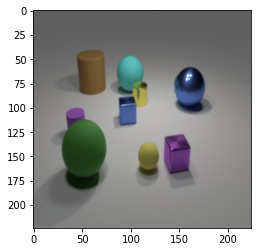

In [70]:
plt.imshow(x1[0].numpy().swapaxes(0,1).swapaxes(1,2))

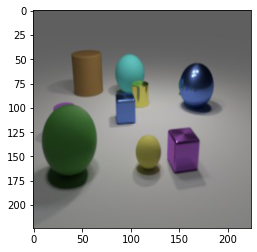

In [71]:
plt.imshow(x2[0].numpy().swapaxes(0,1).swapaxes(1,2))